# Import the needed libraries

In [ ]:
import numpy as np
from collections import Counter
from scipy import stats
from math import log2, sqrt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
import matplotlib.pyplot as plt
import six

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV

# Exploring the dataset

## We are going to use a very famous dataset called [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)

### Dataset attributes 

1. age : continuous variable
2. state_sample	: continuous variable
3. education_num : continuous variable
4. capital_gain : continuous variable
5. capital_loss : continuous variable
6. hours_per_week : continuous variable
7. workclass : categorical variable
8. education : categorical variable
9. marital_status : categorical variable
10. occupation : categorical variable
11. relationship	: categorical variable
12. c1	: categorical variable
13. c2	: categorical variable
14. c3 : categorical variable

# Load the dataset

In [ ]:
columns_names = ['age', 'workclass', 'fnlwg', 'education', 'education_num', 'marital_status',
                 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
                 'country', 'target']

data = pd.read_csv("adult_data.csv", header = None, names = columns_names)
data.head()

,age,workclass,fnlwg,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Describe the dataset

In [ ]:
data.describe()

,age,fnlwg,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwg           32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  country         32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
print(f'dataset shape is {data.shape}')

dataset shape is (32561, 15)


# Data Exploration

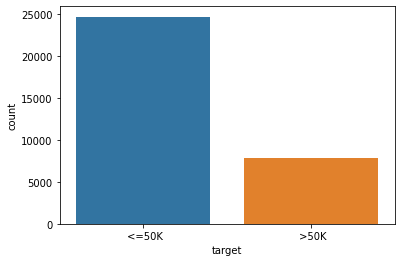

In [ ]:
## Is the dataset balanced?
sns.countplot(x='target',data=data)

# Entropy Implementation

In [ ]:
def entropy(class_y):
    """ 
    Input: 
        - class_y: list of class labels (0's and 1's)
    
    Output: 
        - The entropy
        
    Compute the entropy for a list of classes
    """
    
    # Handling if there is only 1 or 0 labels
    if len(class_y) <= 1: 
        return 0
    
    # Count
    total_count = np.bincount(class_y)
    # Find the probabilities
    probabilities = total_count[np.nonzero(total_count)] / len(class_y) 

    # Handling if the length of the probabilities is less than or equal to 1
    if len(probabilities) <= 1 : 
        return 0
    
    # Entropy equation
    return - np.sum(probabilities * np.log(probabilities)) / np.log(len(probabilities)) 

# Information Gain

In [ ]:
def information_gain(previous_y, current_y):
    """
    Inputs:
        - previous_y : the distribution of original labels (0's and 1's)
        - current_y  : the distribution of labels after splitting based on a particular
                     split attribute and split value
    
    Outputs:
        - info_gain : The information gain after partitioning
        
    Compute and return the information gain from partitioning the previous_y labels into the current_y labels.
    
    """ 
    
    # Y = previous_y
    # X = current_y
    # IG = H(Y) - CE(Y|X)
    conditional_entropy = 0 
    for y in current_y:
        conditional_entropy += (entropy(y)*len(y)/len(previous_y))

    info_gain = entropy(previous_y) - conditional_entropy
    return info_gain

# Test the information gain and the entropy implementations

In [ ]:
# TEST CASE
test_class_y = [0,0,0,1,1,1,1,1]
print(entropy(test_class_y))
 
previous_y = [0,0,0,1,1,1]
current_y = [[0,0], [1,1,1,0]]
print(information_gain(previous_y, current_y))

0.954434002924965
0.4591479170272448


# The Decision Tree ID3 algorithm
1. Find best feature
2. Find best split for the best feature
3. Parition classes based on steps 1 and 2

# Step 3 : Partition Classes

In [ ]:
def partition_classes(X, y, split_attribute, split_val):
    """
    Inputs:
    - X               : (N,D) list containing all data attributes
    - y               : a list of labels
    - split_attribute : column index of the attribute to split on
    - split_val       : either a numerical or categorical value to divide the split_attribute
    
    Outputs:
    - X_left          : X left after partitioning
    - X_right         : X right after partitioning
    - y_left          : y left after partitioning
    - y_right         : y right after partitioning
    
    Partition the data(X) and labels(y) based on the split value    
    """
    """
    Example:
    
    X = [[3, 'aa', 10],                 y = [1,
         [1, 'bb', 22],                      1,
         [2, 'cc', 28],                      0,
         [5, 'bb', 32],                      0,
         [4, 'cc', 32]]                      1]
    
    Here, columns 0 and 2 represent numeric attributes, while column 1 is a categorical attribute.
    
    Consider the case where we call the function with split_attribute = 0 (the index of attribute) and split_val = 3 (the value of attribute).
    Then we divide X into two lists - X_left, where column 0 is <= 3 and X_right, where column 0 is > 3.
    
    X_left = [[3, 'aa', 10],                 y_left = [1,
              [1, 'bb', 22],                           1,
              [2, 'cc', 28]]                           0]
              
    X_right = [[5, 'bb', 32],                y_right = [0,
               [4, 'cc', 32]]                           1]

    Consider another case where we call the function with split_attribute = 1 and split_val = 'bb'
    Then we divide X into two lists, one where column 1 is 'bb', and the other where it is not 'bb'.
        
    X_left = [[1, 'bb', 22],                 y_left = [1,
              [5, 'bb', 32]]                           0]
              
    X_right = [[3, 'aa', 10],                y_right = [1,
               [2, 'cc', 28],                           0,
               [4, 'cc', 32]]                           1]
               
    """
    
    X = np.array(X)
    column_split = X[:, split_attribute]
    X_left = []
    y_right = []
    X_right = []
    y_left = []
    
    # Counter for appending
    counter = 0

    # Numerical attribute
    if isinstance(split_val,str) == False: 
        for i in column_split:
            if i <= split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter += 1

    # Categorical attribute    
    else: 
        for i in column_split:
            # == and NOT <=
            if i == split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter += 1

    return X_left, X_right, y_left, y_right 

# Step 2 : Find Best Split

In [ ]:
def find_best_split(X, y, split_attribute):
    
    """
    Inputs:
        - X               : (N,D) list containing all data attributes
        - y               : a list array of labels
        - split_attribute : Column of X on which to split
    
    Outputs:
        - best_split_val  : optimal split value for a given attribute
        - best_info_gain  : the corresponding information gain
    
    Compute and return the optimal split value for a given attribute, along with the corresponding information gain

    """
    
    """
    
      Example:
    
        X = [[3, 'aa', 10],                 y = [1,
             [1, 'bb', 22],                      1,
             [2, 'cc', 28],                      0,
             [5, 'bb', 32],                      0,
             [4, 'cc', 32]]                      1]
    
        split_attribute = 0
        
        Starting entropy: 0.971
        
        Calculate information gain at splits:
           split_val = 1  -->  info_gain = 0.17
           split_val = 2  -->  info_gain = 0.01997
           split_val = 3  -->  info_gain = 0.01997
           split_val = 4  -->  info_gain = 0.32
           split_val = 5  -->  info_gain = 0
        
       best_split_val = 4; info_gain = .32; 
    """
    
    # Initialize the best information gain
    best_info_gain = 0 
    X = np.array(X)
    column_split = X[:,split_attribute]

    # Get the unique values only !
    column_split = np.unique(column_split)
    # Set the best split as the initial one (in case it is the only one)
    best_split_val = column_split[0] 

    for split_val in column_split:
        # Call the partition classes function
        current_X_left, current_X_right, current_y_left, current_y_right = partition_classes(X, y, split_attribute, split_val)
        current_y = []
        current_y.append(current_y_left)
        current_y.append(current_y_right)

        # Calculate the information gain
        current_info_gain = information_gain(y,current_y)
        # Check if it is better than before
        if current_info_gain > best_info_gain:
            best_info_gain = current_info_gain
            best_split_val = split_val

    return best_split_val, best_info_gain

# Step 1 : Find Best Feature

In [ ]:
def find_best_feature(X, y):
    """
    Inputs:
        - X              : (N,D) list containing all data attributes
        - y              : a list of labels
    
    Outputs:
        - best_feature   : Best Feature to split on
        - best_split_val : Best Split Value for this feature
        
    Compute and return the optimal attribute to split on and optimal splitting value
    """
    
    """
        
    Example:
    
        X = [[3, 'aa', 10],                 y = [1,
             [1, 'bb', 22],                      1,
             [2, 'cc', 28],                      0,
             [5, 'bb', 32],                      0,
             [4, 'cc', 32]]                      1]
    
        split_attribute = 0
        
        Starting entropy: 0.971
        
        Calculate information gain at splits:
           feature 0:  -->  info_gain = 0.32
           feature 1:  -->  info_gain = 0.17
           feature 2:  -->  info_gain = 0.4199
        
       best_split_feature: 2 best_split_val: 22
    """
    
    
    best_info_gain = 0
    best_feature = 0
    best_split_val = 0
    # Loop over the features, find the best split 
    for feature_index in range(len(X[0])):
        current_best_split_val, current_best_info_gain =  find_best_split(X, y,  feature_index)
        if current_best_info_gain > best_info_gain:
            best_info_gain = current_best_info_gain
            best_feature = feature_index
            best_split_val = current_best_split_val
    return best_feature, best_split_val

# Decision Tree ID3 Full Algorithm : Putting Everything Together

In [ ]:
class MyDecisionTree(object):
    def __init__(self, max_depth=None):
        """        
        Args:
        
        max_depth: maximum depth of the tree including the root node.
        """
        self.tree = {}
        # For prediction
        self.residual_tree = {}
        self.max_depth = max_depth

        
    def fit(self, X, y, depth):
        """
        Args:
        X     : N*D matrix corresponding to the data points
        Y     : N*1 array corresponding to the labels of the data points
        depth : depth of node of the tree
        
        Output:
        node : A dictionary that contains this node information
        """

        # Base cases
        unique_labels = np.unique(y) 
        # If we reach the maximum depth or the unique labels = 1
        if (len(unique_labels) == 1) or (depth == max_depth):
            unique_labels, counts_unique_labels = np.unique(y, return_counts=True)
            index = counts_unique_labels.argmax()
            classification = unique_labels[index]    
            return classification
    
        # Find best feature (Step 1)
        best_feat, best_split  = find_best_feature(X, y)
        # Split on this feature (Step 2) - (Redundant)
        best_split, information_gain = find_best_split(X, y, best_feat)
        # Partition on the best feature and split (Step 3)
        X_left, X_right, y_left, y_right = partition_classes(X, y, best_feat, best_split)
        
        if isinstance(best_split,str):
            # Represnt the sub-tree as a question and an answer
            question = "{} == {}".format(best_feat, best_split)
        else:
            # Represnt the sub-tree as a question and an answer
            question = "{} <= {}".format(best_feat, best_split)
        node = {question: []}
        
        # Find answers (recursion)
        depth+=1 
        # RECURSION on the left sub tree
        yes_answer = self.fit(X_left,y_left, depth)
        # RECURSION on the right sub tree
        no_answer = self.fit(X_right, y_right, depth)
        
        # Both trees are the same
        if yes_answer == no_answer:
            node = yes_answer
        else:
            # Append the questions to the answers
            node[question].append(yes_answer)
            node[question].append(no_answer)
        # The tree is equal to the node
        self.tree = node
        return node
        
    def predict(self, record,flag=1):
        """
        Args:
        
        record: D*1, a single data point that should be classified
        
        Output:
        prediction: True if the predicted class label is 1, False otherwise      
        
        classify a sample in test data set using self.tree and return the predicted label
        """
        # First time
        if flag == 1:
            self.residual_tree = self.tree
        question = list(self.residual_tree.keys())[0]
        # Split the question to get the feature and its value
        feature, comparison, value = question.split()

        
        # Check if str or int
        # String
        if comparison == "==": 
            if record[int(feature)] == value:
                # Left sub tree
                answer = self.residual_tree[question][0]
            else:
                # Right sub-tree
                answer = self.residual_tree[question][1]
        # Integer
        elif comparison == "<=": 
            if record[int(feature)] <= float(value):
                # Right Sub-tree
                answer = self.residual_tree[question][0]
            else:
                # Left sub-tree
                answer = self.residual_tree[question][1]

        # Base case
        # If we have the answer
        if not isinstance(answer, dict):
            return answer
    
        # Recursion
        else:
            # The residual tree is the answer!
            self.residual_tree = answer
            # have flag = 0 so the residual tree is our sub-problem
            return self.predict(record,0)

# Evaluate the ID3 implementation

In [ ]:
def DecisionTreeEvalution(id3,X,y, verbose=False):
    y_predicted = []
    for record in X: 
        y_predicted.append(id3.predict(record))
    # Comparing predicted and true labels
    results = [prediction == truth for prediction, truth in zip(y_predicted, y)]
    # Accuracy
    accuracy = float(results.count(True)) / float(len(results))
    if verbose:
        print("accuracy: %.4f" % accuracy)
    return accuracy

In [ ]:
columns_names = ['age', 'workclass', 'fnlwg', 'education', 'education_num', 'marital_status',
                 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
                 'country', 'target']

df_train = pd.read_csv("adult_data.csv", header = None, names = columns_names)
df_train.drop(columns="fnlwg", inplace=True)
df_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
columns_names = ['age', 'workclass', 'fnlwg', 'education', 'education_num', 'marital_status',
                 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
                 'country', 'target']

df_test = pd.read_csv("adult_test.csv", header = None, names = columns_names)
df_test.drop(columns="fnlwg", inplace=True)
df_test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [ ]:
df_test = df_test.iloc[1:]
df_test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
1,25,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [ ]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
print(y_train.head())
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
print(y_train)

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: target, dtype: object
[0 0 0 ... 0 0 1]


In [ ]:
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]
print(y_test.head())
label_enc = LabelEncoder()
y_test = label_enc.fit_transform(y_test)
print(y_test)

1     <=50K.
2     <=50K.
3      >50K.
4      >50K.
5     <=50K.
Name: target, dtype: object
[0 0 1 ... 0 0 1]


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education_num   32561 non-null  int64 
 4   marital_status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital_gain    32561 non-null  int64 
 10  capital_loss    32561 non-null  int64 
 11  hours_per_week  32561 non-null  int64 
 12  country         32561 non-null  object
 13  target          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [ ]:
df_test['age'] = pd.to_numeric(df_test['age'])

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 1 to 16281
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             16281 non-null  int64  
 1   workclass       16281 non-null  object 
 2   education       16281 non-null  object 
 3   education_num   16281 non-null  float64
 4   marital_status  16281 non-null  object 
 5   occupation      16281 non-null  object 
 6   relationship    16281 non-null  object 
 7   race            16281 non-null  object 
 8   sex             16281 non-null  object 
 9   capital_gain    16281 non-null  float64
 10  capital_loss    16281 non-null  float64
 11  hours_per_week  16281 non-null  float64
 12  country         16281 non-null  object 
 13  target          16281 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 1.7+ MB


# Convert the dataframes to numpy arrays as our implementation works on NumPy arrays

In [ ]:
X_train , X_test = X_train.to_numpy() , X_test.to_numpy()
max_depth = 3
inital_depth = 0
id3_dt = MyDecisionTree(max_depth)
# Building a tree
print("fitting the decision tree")
id3_dt.fit(X_train, y_train, inital_depth)

# Evaluating the decision tree
DecisionTreeEvalution(id3_dt,X_test,y_test, True)

fitting the decision tree
accuracy: 0.8031


0.8030833486886555

# What is the final tree

In [ ]:
id3_dt.tree

{'4 ==  Married-civ-spouse': [{'3 <= 12': [{'9 <= 5013': [0, 1]}, 1]},
  {'9 <= 6849': [0, {'0 <= 20': [0, 1]}]}]}

# Compare with Sklearn Decision Tree

In [ ]:
X_train = df_train.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]

In [ ]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

In [ ]:
set(X_train_encoded.columns) - set(X_test_encoded.columns)

{'country_ Holand-Netherlands'}

In [ ]:
X_train_encoded.drop(columns = "country_ Holand-Netherlands", inplace = True)
X_train_encoded.head()

,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,country_ Cambodia,country_ Canada,country_ China,country_ Columbia,country_ Cuba,country_ Dominican-Republic,country_ Ecuador,country_ El-Salvador,country_ England,country_ France,country_ Germany,country_ Greece,country_ Guatemala,country_ Haiti,country_ Honduras,country_ Hong,country_ Hungary,country_ India,country_ Iran,country_ Ireland,country_ Italy,country_ Jamaica,country_ Japan,country_ Laos,country_ Mexico,country_ Nicaragua,country_ Outlying-US(Guam-USVI-etc),country_ Peru,country_ Philippines,country_ Poland,country_ Portugal,country_ Puerto-Rico,country_ Scotland,country_ South,country_ Taiwan,country_ Thailand,country_ Trinadad&Tobago,country_ United-States,country_ Vietnam,country_ Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)
clf.fit(X_train_encoded, y_train)
y_pred = clf.predict(X_test_encoded)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8447884036607088


# Visualize the tree

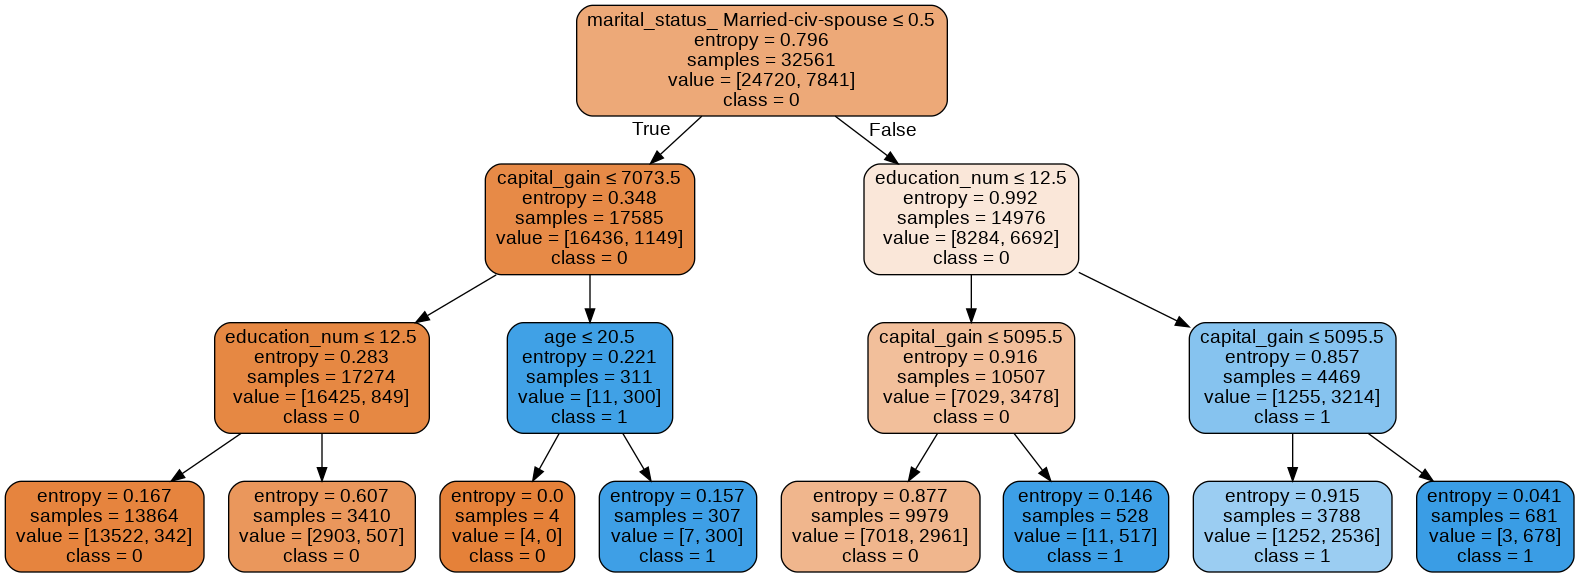

In [ ]:
feature_names = list(X_train_encoded.columns)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('credit_tree.png')
Image(graph.create_png())

In [ ]:
id3_dt.tree

{'4 ==  Married-civ-spouse': [{'3 <= 12': [{'9 <= 5013': [0, 1]}, 1]},
  {'9 <= 6849': [0, {'0 <= 20': [0, 1]}]}]}

# Plot the features importance

In [ ]:
feature_names = list(X_train_encoded.columns)
num_features = len(feature_names)
# Most important line in this cell
importances = clf.feature_importances_

df_importance = pd.DataFrame({"names": feature_names, "importance": importances})

df_importance = df_importance.sort_values('importance', ascending = False).reset_index()
df_importance.head()

,index,names,importance
0,29,marital_status_ Married-civ-spouse,0.539871
1,2,capital_gain,0.250352
2,1,education_num,0.207548
3,0,age,0.002230
4,95,country_ United-States,0.000000


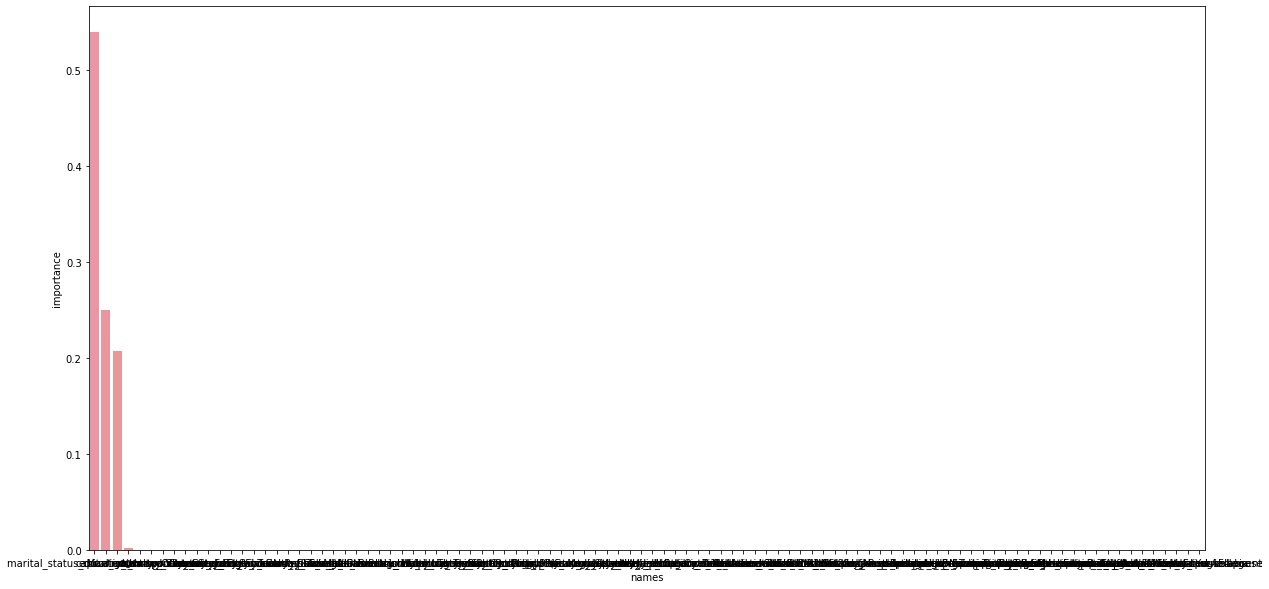

In [ ]:
plt.figure(figsize=(20, 10))

sns.barplot(data = df_importance, x = 'names', y = 'importance')

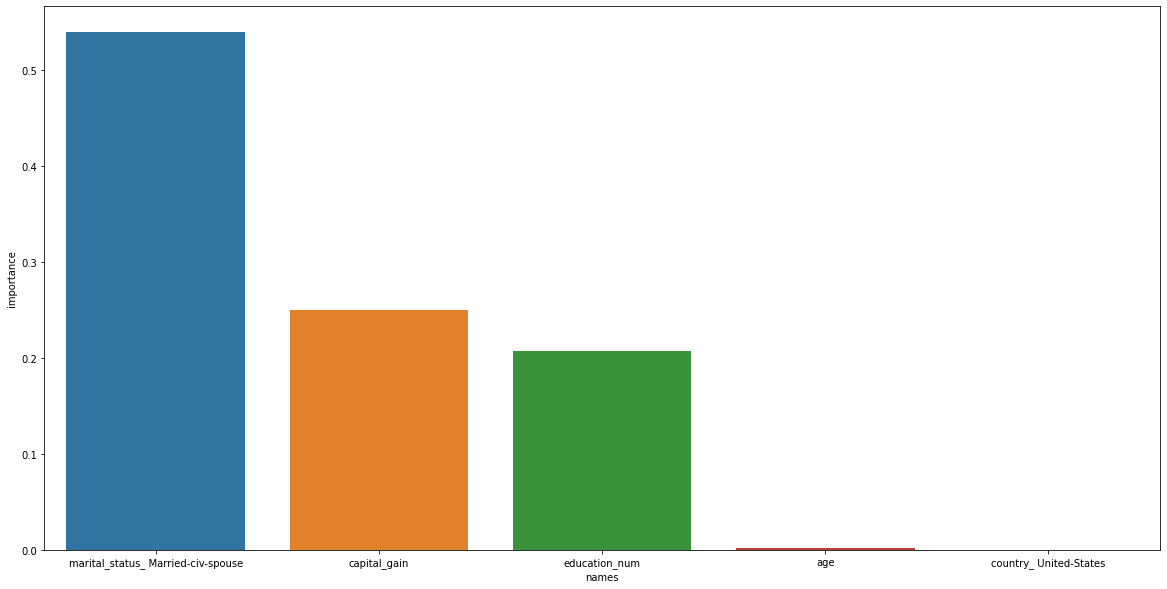

In [ ]:
plt.figure(figsize=(20, 10))

sns.barplot(data = df_importance.iloc[:5, :], x = 'names', y = 'importance')

# Hyperparameter tuning

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = max_depth)

print("Start fitting the data")

hp = {"criterion":['gini','entropy'], 'max_depth':np.arange(3,9)}
for cv in tqdm(range(3,6)):
    grid = GridSearchCV(clf, param_grid = hp, cv = cv)
    grid.fit(X_train_encoded, y_train)
    print(f"score for {cv} fold CV is: {grid.score(X_test_encoded, y_test)}")
    print(f"Best result: {grid.best_params_}")

Start fitting the data


  0%|          | 0/3 [00:00<?, ?it/s]

score for 3 fold CV is: 0.8558442356120631
Best result: {'criterion': 'entropy', 'max_depth': 7}
score for 4 fold CV is: 0.8570726613844358
Best result: {'criterion': 'gini', 'max_depth': 8}
score for 5 fold CV is: 0.8568883975185799
Best result: {'criterion': 'gini', 'max_depth': 8}


# Pruning

## Avoiding Overfitting:

1. Acquire more training data


2. Remove irrelevant attributes


3. **Grow full tree, then post-prune** 


4. Ensemble learning. 


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

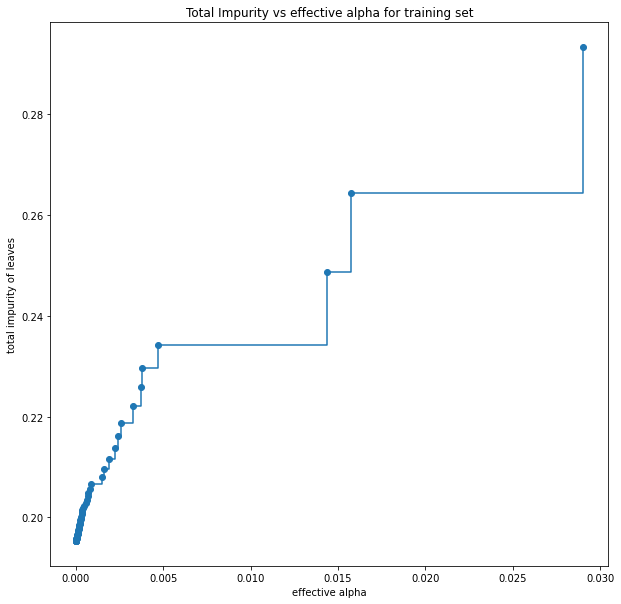

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 7)
clf.fit(X_train_encoded, y_train)

# Pruning!
path = clf.cost_complexity_pruning_path(X_train_encoded, y_train)

# Alpha we have been talking about
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_encoded, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.07230714203644523


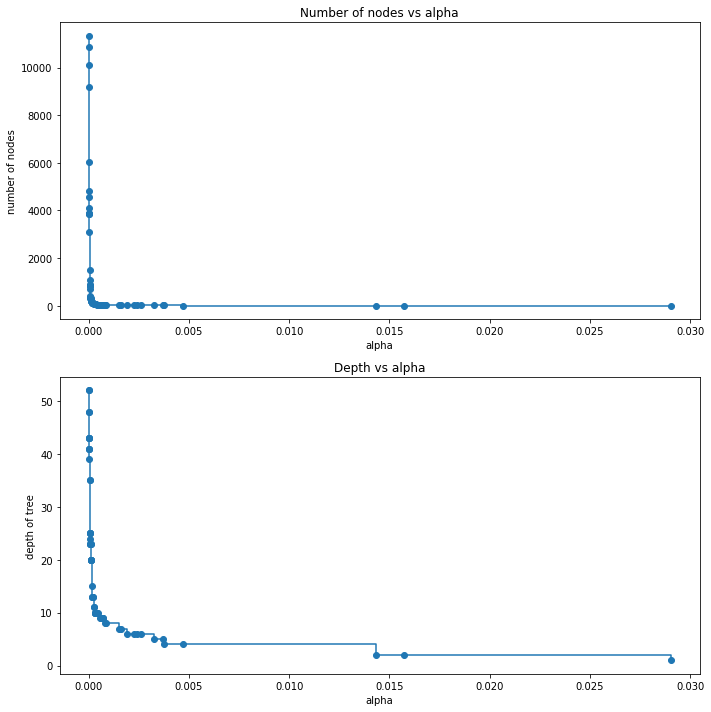

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1,figsize=(10,10))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

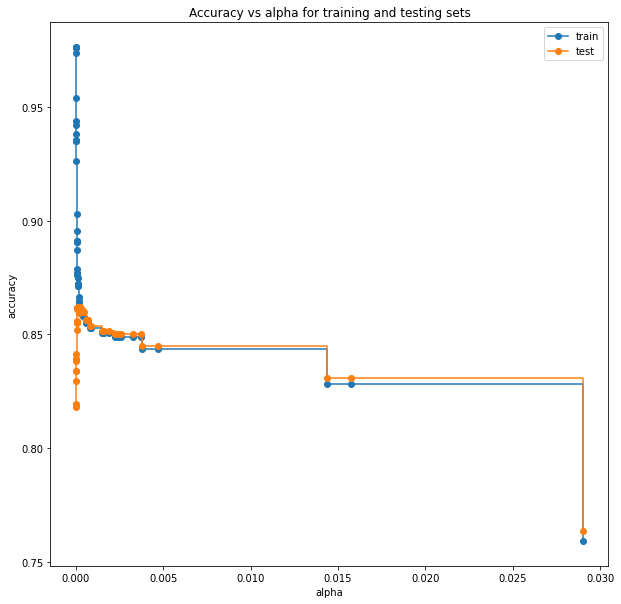

In [ ]:
train_scores = [clf.score(X_train_encoded, y_train) for clf in clfs]
test_scores = [clf.score(X_test_encoded, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
ccp_alphas

array([0.00000000e+00, 4.52924441e-06, 1.01914941e-05, 1.48365157e-05,
       2.43742758e-05, 2.77725216e-05, 2.85769749e-05, 2.98732205e-05,
       3.04337182e-05, 3.05314984e-05, 3.06049500e-05, 3.46860282e-05,
       4.56020541e-05, 5.23713387e-05, 5.63155619e-05, 5.64162528e-05,
       5.67732441e-05, 5.72281284e-05, 6.12902244e-05, 7.91222229e-05,
       8.55680033e-05, 9.02954115e-05, 9.21347624e-05, 1.01294817e-04,
       1.09570700e-04, 1.13807602e-04, 1.13955070e-04, 1.17288969e-04,
       1.33406932e-04, 1.71206872e-04, 1.89195350e-04, 1.90523318e-04,
       2.01932103e-04, 2.31598636e-04, 2.64642403e-04, 2.65720507e-04,
       3.04556847e-04, 3.08830557e-04, 3.26987526e-04, 3.35180885e-04,
       3.69298019e-04, 4.21547180e-04, 4.41361922e-04, 5.73729075e-04,
       6.19256891e-04, 7.08793923e-04, 7.10008778e-04, 7.97026299e-04,
       8.81894118e-04, 1.48945797e-03, 1.59260428e-03, 1.91482886e-03,
       2.24454089e-03, 2.42344290e-03, 2.58529868e-03, 3.26793790e-03,
      

## Decision Tree Pros and Cons


| Pros | Cons
| --- | --- 
|Easy to interpret and visualize.| Sensitive to noisy data. It can overfit noisy data.
|Has no assumptions about distribution because of the non-parametric nature of the algorithm.|The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
|Can easily capture Non-linear patterns.|Biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.
|It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.|Greedy algorithms don’t yield the global optimum tree structure.
|It can be used for feature engineering such as predicting missing values, suitable for variable selection.| As the branching goes deeper, you get exponentially less data.
|It has no problem whether the inputs and outputs are binary, categorical or continuous